# Приложение для доставки еды. A/A/B-эксперимент. Воронка продаж.

## Описание проекта

Требуется изучить, как ведут себя пользователи мобильного приложения. Приложение разработано для стартапа, который продаёт продукты питания.

**Цель работы:**

Целями работы являются проведение А/А/В теста и формулировка выводов по его результатам.

**План работы:**

* Подготовка данных для анализа
* Изучение данных, проверка их на наличие выбросов
* Определения периода с полными данными о логах
* Отсечение периода с неполными данными
* Проверка влияния потери данных на дальнейший ход исследования
* Изучение продуктовой воронки, определение доли потерь на каждом шаге
* Определение шага с наибольшими потерями пользователей
* Определение порядка шагов в цепи событий
* Анализ шагов воронки
* Изучение результатов эксперимента
* Проверка функции для проверки различий между группами на группах А и А1
* Сравнение групп А и В
* Сравнение групп А1 и В
* Сравнение групп А+А1 и В
* Проверка влияния коэфициента значимости на результаты теста

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие. 

* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Выполнение: 

## Откроем файл с данными и изучите общую информацию

**Импортирую библиотеки:**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
from scipy import stats as st
import math as mth
from plotly import graph_objects as go
from matplotlib import pyplot as plt
import scipy.stats as stats

**Импортирую данные:**

In [2]:
# Читаем csv-файл с помощью pandas:
try:
    logs_exp = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    logs_exp = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

**Знакомлюсь с данными:**

In [3]:
pd.options.display.max_colwidth = 130

display(logs_exp.head(5));

EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

## Готовим данные

**Замените названия столбцов на удобные для вас:**

In [4]:
logs_exp.columns

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

In [5]:
logs_exp.columns = ['eventname', 'deviceidhash', 'eventtimestamp', 'expid']

In [6]:
logs_exp.columns

Index(['eventname', 'deviceidhash', 'eventtimestamp', 'expid'], dtype='object')

Приведу ещё названия событий к snakecase.

In [7]:
logs_exp['eventname'] = logs_exp['eventname'].str.lower().str.replace(' ','_')

In [8]:
display(logs_exp.head(5));

eventname         deviceidhash  eventtimestamp  expid
0         mainscreenappear  4575588528974610257      1564029816    246
1         mainscreenappear  7416695313311560658      1564053102    246
2  paymentscreensuccessful  3518123091307005509      1564054127    248
3         cartscreenappear  3518123091307005509      1564054127    248
4  paymentscreensuccessful  6217807653094995999      1564055322    248

**Проверяю типы данных и наличие пропусков:**

In [9]:
logs_exp.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   eventname       244126 non-null  object
 1   deviceidhash    244126 non-null  int64 
 2   eventtimestamp  244126 non-null  int64 
 3   expid           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [10]:
logs_exp.shape

(244126, 4)

Тип данных в столбце eventtimestamp менять не будем, так как сделаем для работы отдельные столбцы с датой и с датой и временем:

In [11]:
display(logs_exp.head(5));

eventname         deviceidhash  eventtimestamp  expid
0         mainscreenappear  4575588528974610257      1564029816    246
1         mainscreenappear  7416695313311560658      1564053102    246
2  paymentscreensuccessful  3518123091307005509      1564054127    248
3         cartscreenappear  3518123091307005509      1564054127    248
4  paymentscreensuccessful  6217807653094995999      1564055322    248

Проверяю данные на наличие пропусков в каждом отдельном столбце "logs_exp":

In [12]:
logs_exp.isna().sum()

eventname         0
deviceidhash      0
eventtimestamp    0
expid             0
dtype: int64

Пропуски в logs_exp отсутствуют.

Проверяю logs_exp на наличие явных дубликатов:

In [13]:
logs_exp.duplicated().sum()

413

In [14]:
logs_exp = logs_exp.drop_duplicates()

In [15]:
logs_exp.shape

(243713, 4)

Так как потеря данных составляет менее одного процента, удаление дубликатов не должно отразиться на результатах исследования.

**Добавьте столбец даты и времени, а также отдельный столбец дат:**

In [16]:
logs_exp['date_time'] = pd.to_datetime(logs_exp['eventtimestamp'], unit='s')
logs_exp['date'] = logs_exp['date_time'].dt.floor('D')

In [17]:
display(logs_exp.head(5));

eventname         deviceidhash  eventtimestamp  expid  \
0         mainscreenappear  4575588528974610257      1564029816    246   
1         mainscreenappear  7416695313311560658      1564053102    246   
2  paymentscreensuccessful  3518123091307005509      1564054127    248   
3         cartscreenappear  3518123091307005509      1564054127    248   
4  paymentscreensuccessful  6217807653094995999      1564055322    248   

            date_time       date  
0 2019-07-25 04:43:36 2019-07-25  
1 2019-07-25 11:11:42 2019-07-25  
2 2019-07-25 11:28:47 2019-07-25  
3 2019-07-25 11:28:47 2019-07-25  
4 2019-07-25 11:48:42 2019-07-25

**Вывод после предобработки данных:**

В "сырых" данных были обнаружениы следующие проблемы:

* Не соответствие стилю  snake case.
* Не соответствие типа данных  в столбце eventtimestamp типу datetime64[D].
* Наличие очевидных дубликатов.

Данные недостатки могут быть вызваны влиянием человеческого фактора при внесении данных.

## Изучим и проверим данные

**Сколько всего событий в логе?**

In [18]:
logs_exp_count = logs_exp['eventname'].count()

logs_exp_count

243713

In [19]:
len_logs_exp = len(logs_exp)

display('Всего событий в логе:', len_logs_exp);

'Всего событий в логе:'

243713

**Сколько всего пользователей в логе?**

In [20]:
logs_exp_nunique = logs_exp['deviceidhash'].nunique()

logs_exp_nunique

7551

**Сколько в среднем событий приходится на пользователя?**

In [21]:
logs_exp.groupby('deviceidhash').agg({'eventname': 'count'}).describe()

eventname
count  7551.000000
mean     32.275593
std      65.154219
min       1.000000
25%       9.000000
50%      20.000000
75%      37.000000
max    2307.000000

Так как на 75% процентиле мы видим значение 37, а максимальное значение 2307 - можно сделать вывод, что в данныз присутствуют выбросы, поэтому среднее количество событий определим по медиане.

In [22]:
events_by_users = logs_exp.groupby('deviceidhash')['eventname'].agg('count').median()

events_by_users

20.0

**За какой период есть данные? Найдём максимальную и минимальную дату. Построим гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. Данными за какой период времени есть на самом деле?**

In [23]:
print('\nНачальная дата {}, конечная дата {}\n'.format(logs_exp['date'].min(), logs_exp['date'].max()))


Начальная дата 2019-07-25 00:00:00, конечная дата 2019-08-07 00:00:00



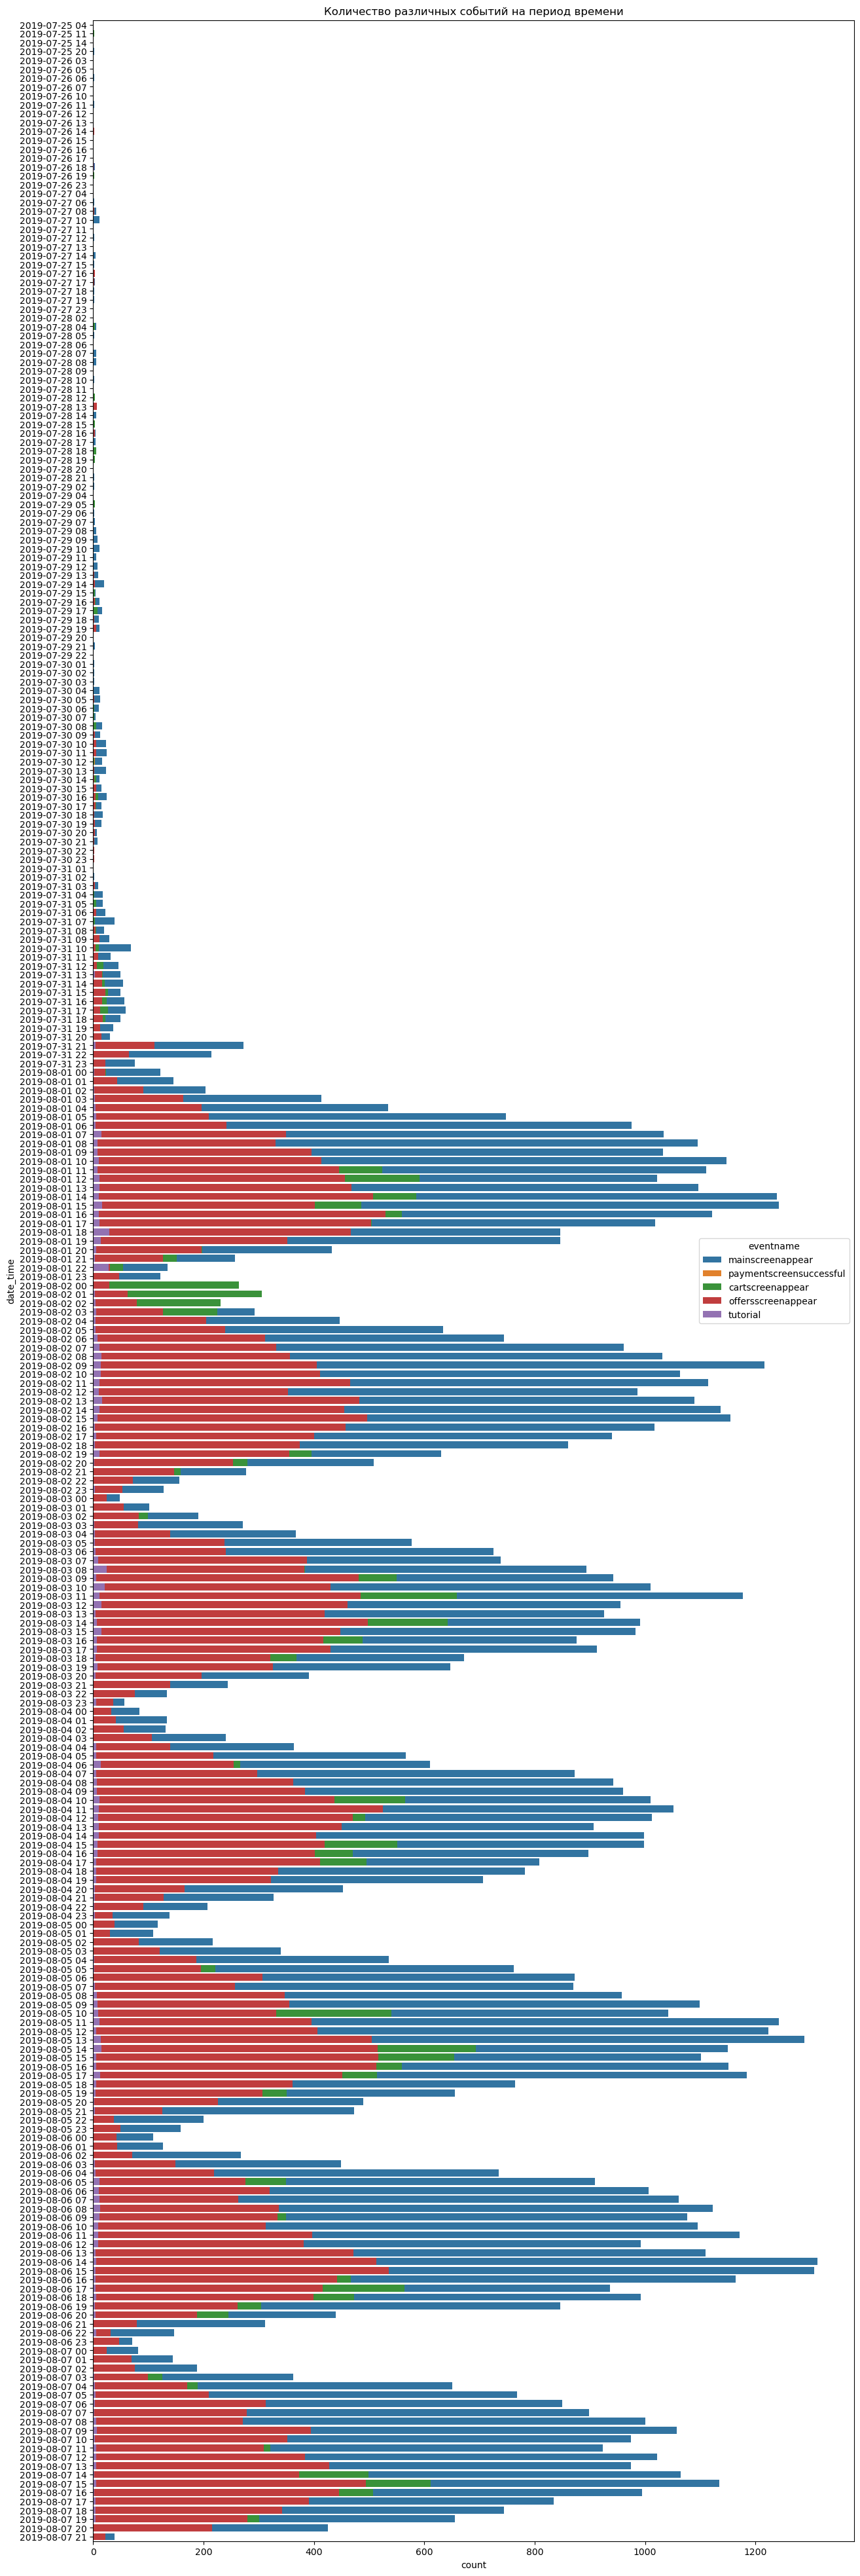

In [24]:
plt.figure(figsize=(15, 50))

ax = sns.countplot(y=logs_exp['date_time'].dt.strftime('%Y-%m-%d %H'), hue='eventname', data=logs_exp, dodge=False)

ax.set_title('Количество различных событий на период времени')

plt.show()

На гистограмме выше видно, что полные данные о логах имеются только за период с 21:00 31.07.2019 по 21:00 07.08.2019.

**Отсекаю данные ранее 21:00 31.07.2019 и сохраняю оставшиеся данные в logs, дальнейший анализ буду проводить по данным logs:**

In [25]:
logs = logs_exp['2019-07-31 21:00' <= logs_exp['date_time']]

display(logs.head(5));

eventname         deviceidhash  eventtimestamp  expid  \
1990    mainscreenappear  7701922487875823903      1564606857    247   
1991    mainscreenappear  2539077412200498909      1564606905    247   
1992  offersscreenappear  3286987355161301427      1564606941    248   
1993  offersscreenappear  3187166762535343300      1564606943    247   
1994    mainscreenappear  1118952406011435924      1564607005    248   

               date_time       date  
1990 2019-07-31 21:00:57 2019-07-31  
1991 2019-07-31 21:01:45 2019-07-31  
1992 2019-07-31 21:02:21 2019-07-31  
1993 2019-07-31 21:02:23 2019-07-31  
1994 2019-07-31 21:03:25 2019-07-31

**Сколько всего событий в логе?**

In [26]:
logs_count = logs['eventname'].count()

logs_count

241724

In [27]:
len_logs = len(logs)

display('Всего событий в логе:', len_logs);

'Всего событий в логе:'

241724

**Сколько всего пользователей в логе?**

In [28]:
logs_nunique = logs['deviceidhash'].nunique()

logs_nunique

7538

**Сколько в среднем событий приходится на пользователя?**

In [29]:
logs.groupby('deviceidhash').agg({'eventname': 'count'}).describe()

eventname
count  7538.000000
mean     32.067392
std      65.161568
min       1.000000
25%       9.000000
50%      19.000000
75%      37.000000
max    2307.000000

Так как на 75% процентиле мы видим значение 37, а максимальное значение 2307 - можно сделать вывод, что в данныз присутствуют выбросы, поэтому среднее количество событий определим по медиане.

In [30]:
events_by_users_logs = logs.groupby('deviceidhash')['eventname'].agg('count').median()

events_by_users_logs

19.0

**Много ли событий и пользователей вы потеряли, отбросив старые данные?**

Сколько потеряно событий в логе:

In [31]:
logs_exp_count - logs_count

1989

Сколько потеряно пользователей:

In [32]:
logs_exp_nunique - logs_nunique

13

**Доля потерь по событиям:**

In [33]:
display(f'Потеряли {len_logs_exp - len_logs} событий, что являлось {round((len_logs_exp - len_logs) / len_logs_exp * 100, 2)}% от общего числа данных')

'Потеряли 1989 событий, что являлось 0.82% от общего числа данных'

**Доля потерь по уникальным пользователям:**

In [34]:
display(f"Потеряли {logs_exp_nunique - logs_nunique} пользователей, что являлось {round((logs_exp_nunique - logs_nunique) / logs_exp_nunique * 100, 2) } % от общего числа пользователей")

'Потеряли 13 пользователей, что являлось 0.17 % от общего числа пользователей'

Доля потерь после отброса пустых логов составила менее одного процента. Удаление пустых логов не должно негативно отразиться на результатах дальнейшего анализа.

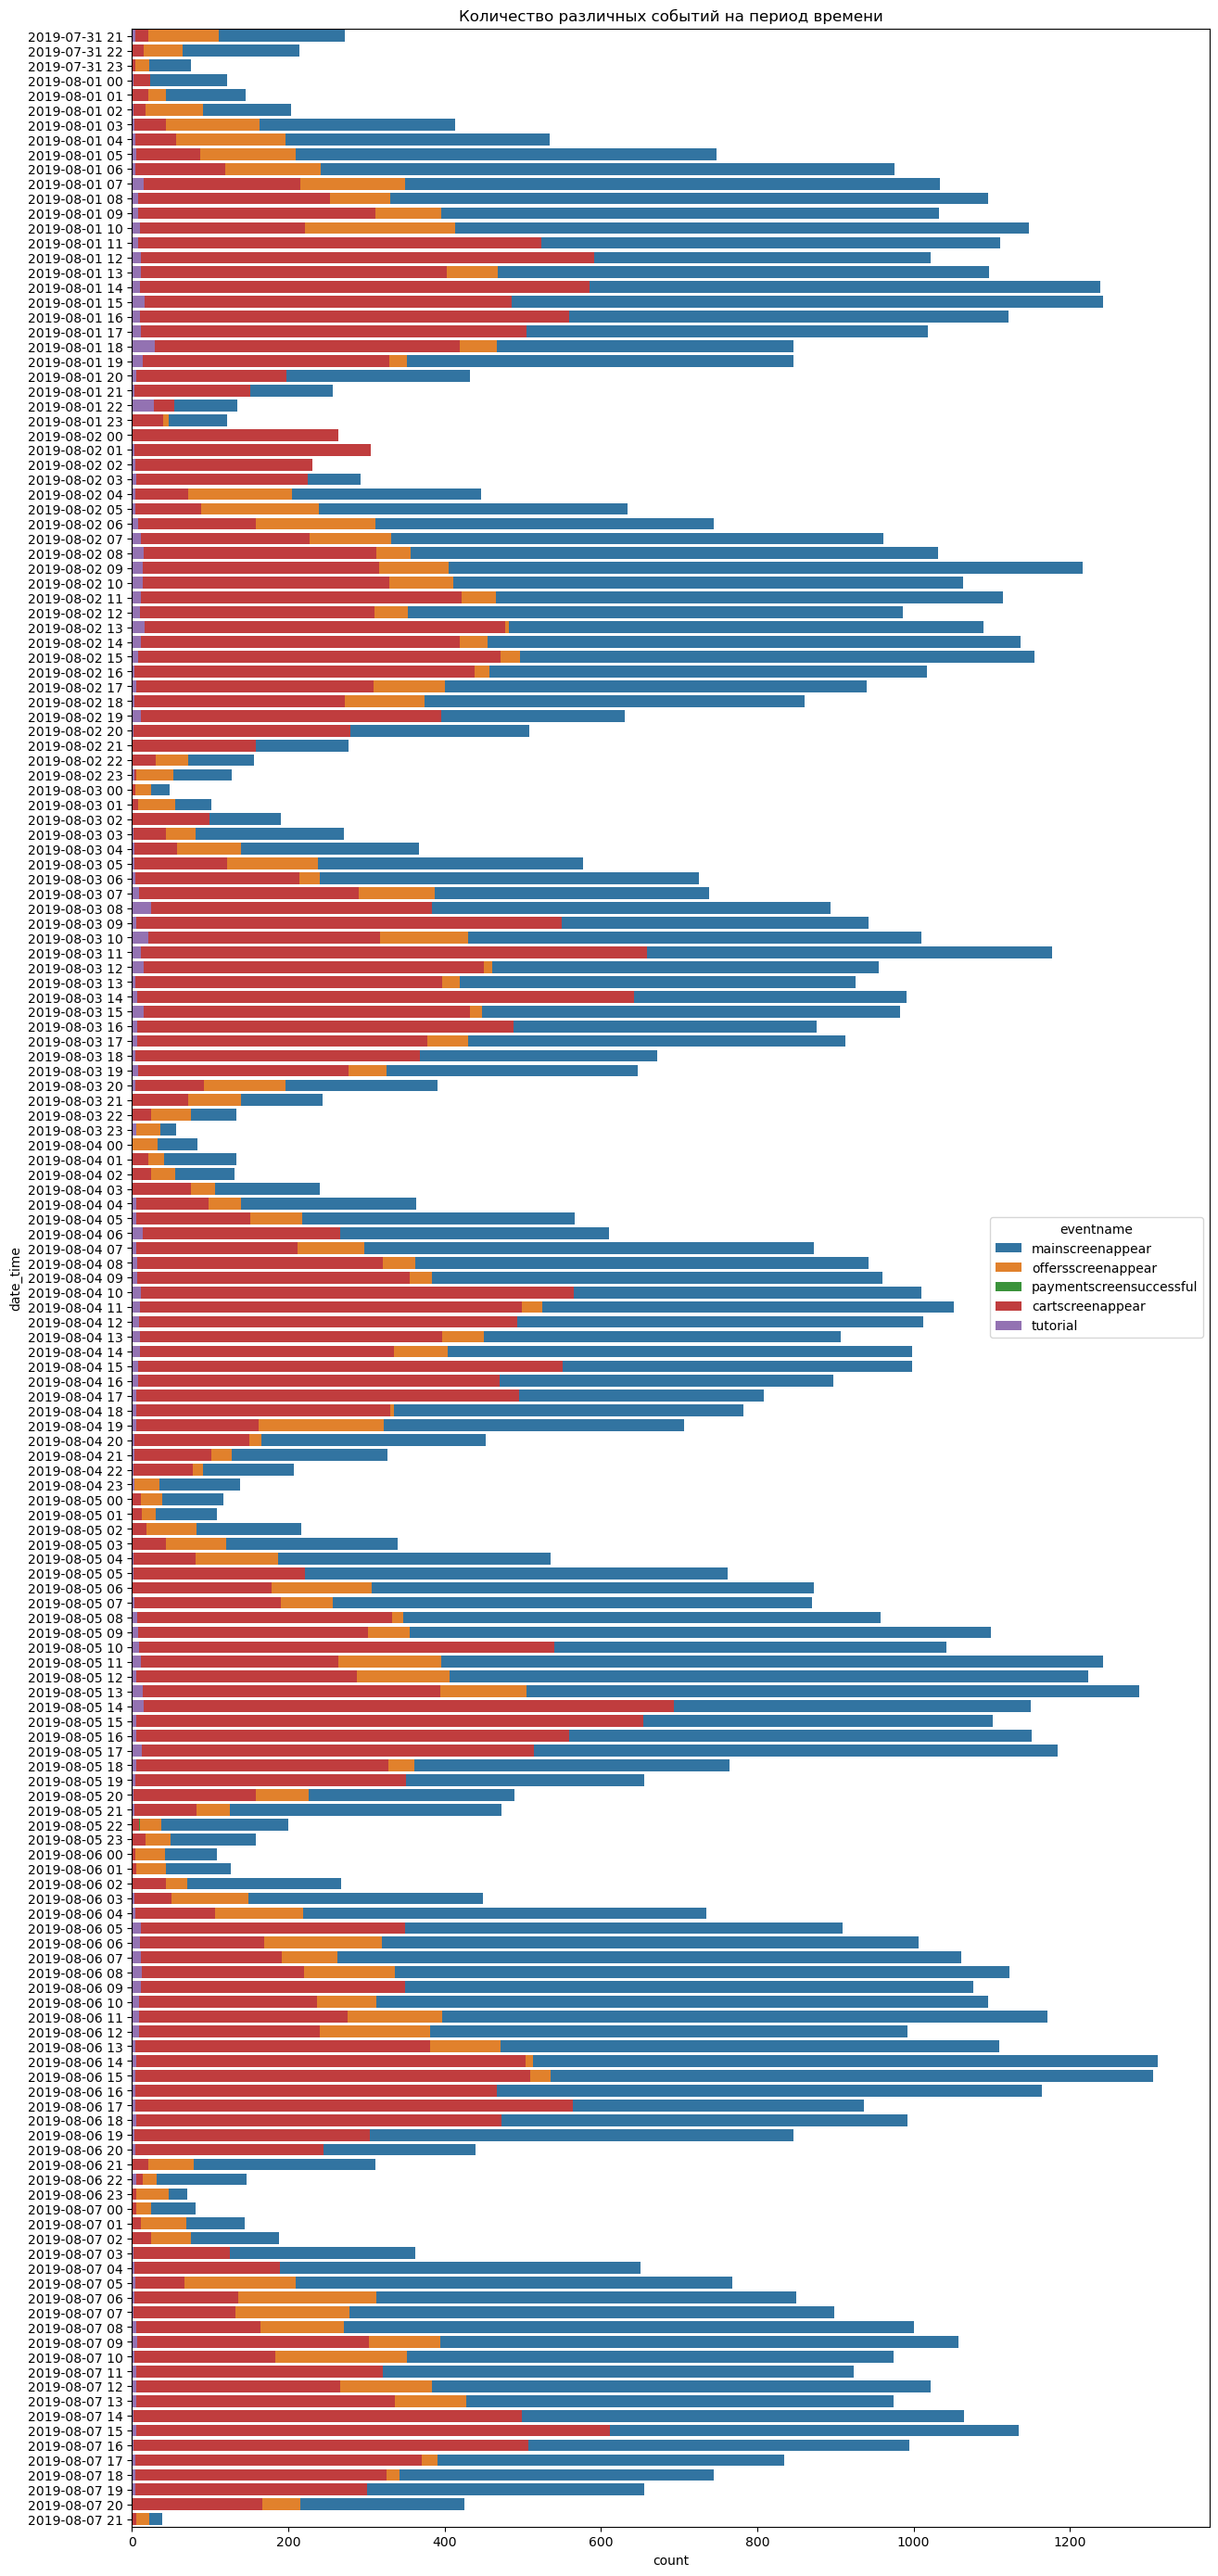

In [35]:
plt.figure(figsize=(15, 35))

ax = sns.countplot(y=logs['date_time'].dt.strftime('%Y-%m-%d %H'), hue='eventname', data=logs, dodge=False)

ax.set_title('Количество различных событий на период времени')

plt.show()

При отсечении неполных данных было потеряно менее 1% информации, поэтому данная процедура не должна повлиять на результаты дальнейшего анализа.

**Проверим, что есть пользователи из всех трёх экспериментальных групп.**

In [36]:
logs.groupby('expid').agg({'deviceidhash': ['count', 'nunique']})

deviceidhash        
             count nunique
expid                     
246          79556    2484
247          77293    2517
248          84875    2537

Количество пользователей в трёх группах не имеет значимого различия.

## Изучим воронку событий

**Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.**

In [37]:
logs['eventname'].value_counts()

mainscreenappear           117889
offersscreenappear          46531
cartscreenappear            42343
paymentscreensuccessful     33951
tutorial                     1010
Name: eventname, dtype: int64

Чаще всего пользователи просматривают главный экран. 

А прохождение обучения нужно будет при построении воронки отсеять, так как этот этап не явдяется шагом воронки.

**Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.**

In [38]:
logs_by_users = logs.groupby('eventname').agg({'deviceidhash': 'nunique'})
logs_by_users['share'] = logs_by_users['deviceidhash'] / logs['deviceidhash'].nunique()
logs_by_users.sort_values(by = 'deviceidhash', ascending = False).style.format({'share':'{:.2%}'})


* 98% пользователей попадают на главную страницу
* 61% пользователей попадают на страницу с предложениями
* 50% пользователей попадают на страницу с корзиной
* 47% пользователей попадают на страницу с уведомлением об успешном проведении платежа
* 11% пользователей попадают на страницу с обучением

Задам переменные для расчёта воронки

In [39]:
mainscreenappear = logs_by_users.loc['mainscreenappear', 'deviceidhash']
offersscreenappear = logs_by_users.loc['offersscreenappear', 'deviceidhash']
cartscreenappear = logs_by_users.loc['cartscreenappear', 'deviceidhash']
paymentscreensuccessful = logs_by_users.loc['paymentscreensuccessful', 'deviceidhash']

Проверю, для надёжности 😄

In [40]:
display(mainscreenappear)
display(offersscreenappear)
display(cartscreenappear)
display(paymentscreensuccessful);

7423

4597

3736

3540

Доля пользователей, которые совершали хотя бы одно событие:

In [41]:
users_with_one_log = logs['deviceidhash'].nunique()

fraction = (logs_by_users/users_with_one_log)*100

fraction.sort_values(by = 'deviceidhash', ascending = False)

deviceidhash     share
eventname                                      
mainscreenappear            98.474396  0.013064
offersscreenappear          60.984346  0.008090
cartscreenappear            49.562218  0.006575
paymentscreensuccessful     46.962059  0.006230
tutorial                    11.183338  0.001484

Похоже, что приложение имеет интуитивно понятный интерфейс, раз обучение проходят всего 11% пользователей.

**Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Нужно ли их учитывать при расчёте воронки?**

На данный момент можно построить цепочку событий согласно количеству посещений пользователей. 

Цепочка может выглядеть следующим образом:

1. Главная страница
2. Страница предложений
3. Страница с покупательской корзиной
4. Страница успешного совершения оплаты

**По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.**

In [42]:
display(f'Количество просмотров главной страницы - {mainscreenappear}')
display(f'Количество просмотров страницы предложений - {offersscreenappear}')
display(f'Количество посещений страницы с корзиной - {cartscreenappear}')
display(f'Количество просмотров страницы с информацией об успешном проведении платежа {paymentscreensuccessful}')

CR_offer = offersscreenappear/mainscreenappear*100
CR_cart = cartscreenappear/offersscreenappear*100
CR_payment = paymentscreensuccessful/cartscreenappear*100

display(f'Конверсия Главная Страница -> Страница Предложений {CR_offer:.2f}')
display(f'Конверсия Главная Предложений -> Страница С Корзиной {CR_cart:.2f}')
display(f'Конверсия Страница С Корзиной -> Страница Успешного Платежа {CR_payment:.2f}')

'Количество просмотров главной страницы - 7423'

'Количество просмотров страницы предложений - 4597'

'Количество посещений страницы с корзиной - 3736'

'Количество просмотров страницы с информацией об успешном проведении платежа 3540'

'Конверсия Главная Страница -> Страница Предложений 61.93'

'Конверсия Главная Предложений -> Страница С Корзиной 81.27'

'Конверсия Страница С Корзиной -> Страница Успешного Платежа 94.75'

**Построим воронку перехода пользователей с одного этапа на следующий:**

Доли относительно количества пользователей посетивших главную страницу и относительно количества пользователей посетивших предыдущую страницу (при наверении курсора на шаг воронки):

In [43]:
data_group = logs.groupby(['eventname', 'expid']).\
agg({'deviceidhash': 'nunique'}).reset_index().sort_values(by=['expid', 'deviceidhash'], ascending=False)
data_group = data_group[data_group['eventname']!='tutorial']
data_group

eventname  expid  deviceidhash
5          mainscreenappear    248          2494
8        offersscreenappear    248          1531
2          cartscreenappear    248          1231
11  paymentscreensuccessful    248          1182
4          mainscreenappear    247          2479
7        offersscreenappear    247          1524
1          cartscreenappear    247          1239
10  paymentscreensuccessful    247          1158
3          mainscreenappear    246          2450
6        offersscreenappear    246          1542
0          cartscreenappear    246          1266
9   paymentscreensuccessful    246          1200

In [44]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    y = data_group.query('expid == 246')['eventname'],
    x = data_group.query('expid == 246')['deviceidhash'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = data_group.query('expid == 247')['eventname'],
    x = data_group.query('expid == 247')['deviceidhash'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = '248',
    orientation = "h",
    y = data_group.query('expid == 248')['eventname'],
    x = data_group.query('expid == 248')['deviceidhash'],
    textposition = "inside",
    textinfo = "value+percent total"))

fig.update_layout(title_text='Воронка событий по тестовым группам', title_x = 0.5)
fig.show()

**На каком шаге теряем больше всего пользователей?**

Больше всего пользователей теряется на этапе перехода с Главной Страницы к Странице Предложений.

**Какая доля пользователей доходит от первого события до оплаты?**

От первого события до оплаты доходит 48% пользователей.

## Изучим результаты эксперимента

**Сколько пользователей в каждой экспериментальной группе?**

In [45]:
logs.groupby('expid').agg({'deviceidhash': ['count', 'nunique']})

deviceidhash        
             count nunique
expid                     
246          79556    2484
247          77293    2517
248          84875    2537

In [46]:
mask_246_247 = logs.loc[logs["expid"]=="246", "deviceidhash"].isin(logs.loc[logs["expid"]=="247", "deviceidhash"])

display(mask_246_247.count())

0

In [47]:
mask_246_248 = logs.loc[logs["expid"]=="246", "deviceidhash"].isin(logs.loc[logs["expid"]=="248", "deviceidhash"])

display(mask_246_248.count())

0

In [48]:
mask_247_248 = logs.loc[logs["expid"]=="247", "deviceidhash"].isin(logs.loc[logs["expid"]=="248", "deviceidhash"])

display(mask_247_248.count())

0

In [49]:
users_in_several_groups = (
    logs.groupby('deviceidhash')
    .agg({'expid':'nunique'})
    .query('expid>1')
    .count()
)

display('Количество уникальных пользователей, попавших в несколько групп:')
display(users_in_several_groups);

'Количество уникальных пользователей, попавших в несколько групп:'

expid    0
dtype: int64

Не обнаружено уникальных пользователей, попавших сразу несколько групп.

In [50]:
events = logs.groupby('eventname')['deviceidhash'].agg(['count', 'nunique']).reset_index()
events.columns =['eventname', 'n_events', 'n_users']
n_users = {'all': logs['deviceidhash'].nunique(), 
           246: logs[logs['expid']==246]['deviceidhash'].nunique(),
           247: logs[logs['expid']==247]['deviceidhash'].nunique(),
           248: logs[logs['expid']==248]['deviceidhash'].nunique(),
           '246+247': logs[(logs['expid']==246) | (logs['expid']==247)]['deviceidhash'].nunique()}

In [51]:
display(events);

eventname  n_events  n_users
0         cartscreenappear     42343     3736
1         mainscreenappear    117889     7423
2       offersscreenappear     46531     4597
3  paymentscreensuccessful     33951     3540
4                 tutorial      1010      843

In [52]:
groups = [246, 247, 248]

print('Для A/A/B-теста пользователей разбили на 3 группы: '
      '2 контрольные(246 и 247) со старыми шрифтами и одну экспериментальную(248) — с новыми.')
print('')
for group in groups:
    n_users
    print('В {} группе {} пользователей'.format(group, n_users[group]))
    print('')

Для A/A/B-теста пользователей разбили на 3 группы: 2 контрольные(246 и 247) со старыми шрифтами и одну экспериментальную(248) — с новыми.

В 246 группе 2484 пользователей

В 247 группе 2517 пользователей

В 248 группе 2537 пользователей



In [53]:
users_by_expid = logs.groupby('expid').agg({'deviceidhash': 'nunique'})

display(users_by_expid);

deviceidhash
expid              
246            2484
247            2517
248            2537

In [54]:
total_246 = users_by_expid.loc[246]
total_247 = users_by_expid.loc[247]
total_248 = users_by_expid.loc[248]

In [55]:
users_by_expid_c = logs.groupby('expid').agg({'deviceidhash': 'count'})

display(users_by_expid_c);

deviceidhash
expid              
246           79556
247           77293
248           84875

In [56]:
total_c_246 = users_by_expid_c.loc[246]
total_c_247 = users_by_expid_c.loc[247]
total_c_248 = users_by_expid_c.loc[248]

**Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.**

Формулирую гипотезы:

* Н0: Статистические критерии не находят разницу между выборками 246 и 247.
* Н1: Статистические критерии находят разницу между выборками 246 и 247.

Задаю функцию для проверки различий:

In [57]:
def hypothesis_test(achievement1, achievement2, attempt1, attempt2, alpha):
    
    alpha = alpha
    
    # достижения в первой группе:
    p1 = achievement1/attempt1
 
    # достижения во второй группе:
    p2 = achievement2/attempt2
 
    # пропорция комбинированной таблице:
    p_combined = (achievement1 + achievement2) / (attempt1 + attempt2)
 
    # разница пропорций в таблицах
    difference = p1 - p2
    
    # расчёт статистики в ст.отклонениях стандартного нормального распределения
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/attempt1 + 1/attempt2))
 
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1) 
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    print('уровень значимости: ', alpha)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [58]:
def z_test(events_1, events_2, users_1, users_2, alpha):

    # по методу Бонферрони снизим уровень значимости в 16 раз, так как проводим 16 тестов:
    alpha = alpha/16
    
    # пропорция успехов в первой группе:
    p1 = events_1/users_1
    
    # пропорция успехов во второй группе:
    p2 = events_2/users_2
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (events_1 + events_2) / (users_1 + users_2)
    
    # разница пропорций в датасетах:
    difference = p1 - p2
    
    # считаем статистику в статистических отклонениях стандартного нормального распределения:
    z_value = difference / mth.sqrt (p_combined * (1 - p_combined) * (1/users_1 + 1/users_2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1) 
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    print('уровень значимости: ', alpha)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

**Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Сделаем вывод о том, можно ли сказать, что разбиение на группы работает корректно?**

Выбираю самое популярное событие:

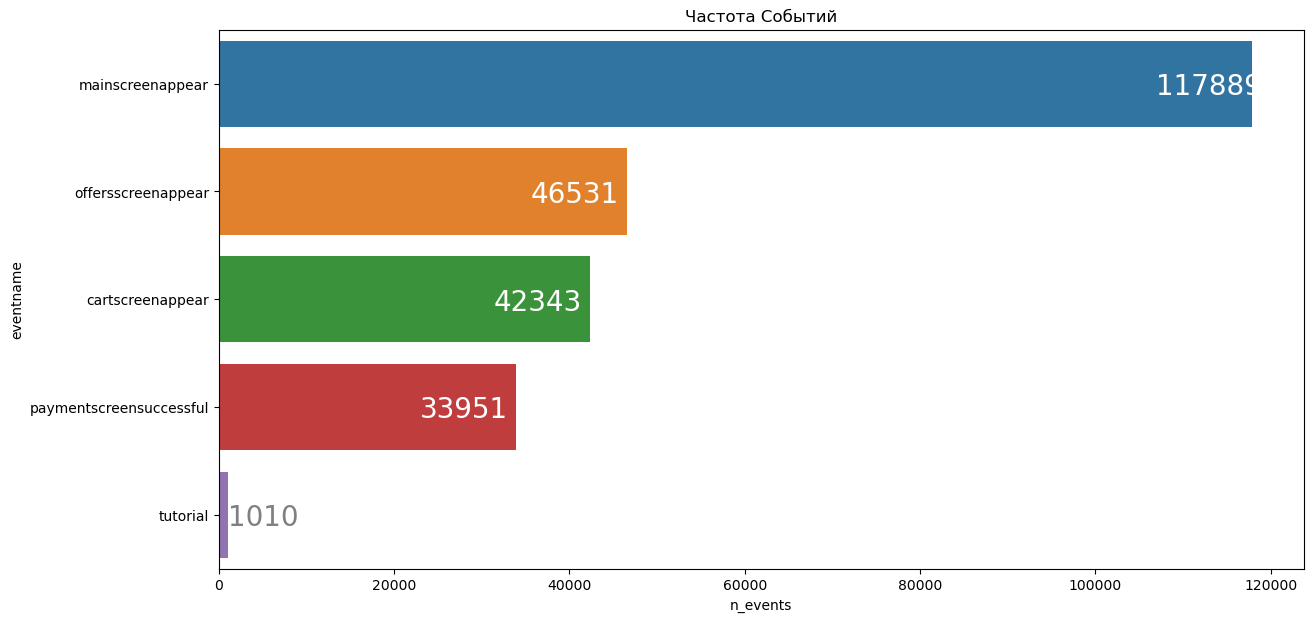

In [59]:
plt.figure(figsize=(14, 7))
order = events.sort_values('n_events', ascending=False).reset_index(drop=True)['eventname']
ax = sns.barplot(y='eventname', x='n_events', order = order,  data=events)
ax.set_title('Частота Событий')
for i in ax.patches:
    if i.get_width() > 20000:
        ax.text(i.get_width()-11000, i.get_y()+0.5, 
                str(int(i.get_width())), fontsize=20, color='white')
    else:
        ax.text(i.get_width()+30, i.get_y()+0.5, 
                str(int(i.get_width())), fontsize=20, color='grey')
plt.show()

Считаю число пользователей, совершивших каждое событие в каждой из контрольных групп:

In [60]:
event_pivot = logs.pivot_table(index=['eventname', 'expid'], values='deviceidhash', aggfunc=['count', 'nunique']).reset_index()
event_pivot.columns= ['eventname', 'expid', 'n_events', 'n_users']

display(event_pivot);

eventname  expid  n_events  n_users
0          cartscreenappear    246     14697     1266
1          cartscreenappear    247     12439     1239
2          cartscreenappear    248     15207     1231
3          mainscreenappear    246     37855     2450
4          mainscreenappear    247     39294     2479
5          mainscreenappear    248     40740     2494
6        offersscreenappear    246     14829     1542
7        offersscreenappear    247     15237     1524
8        offersscreenappear    248     16465     1531
9   paymentscreensuccessful    246     11858     1200
10  paymentscreensuccessful    247      9983     1158
11  paymentscreensuccessful    248     12110     1182
12                 tutorial    246       317      278
13                 tutorial    247       340      284
14                 tutorial    248       353      281

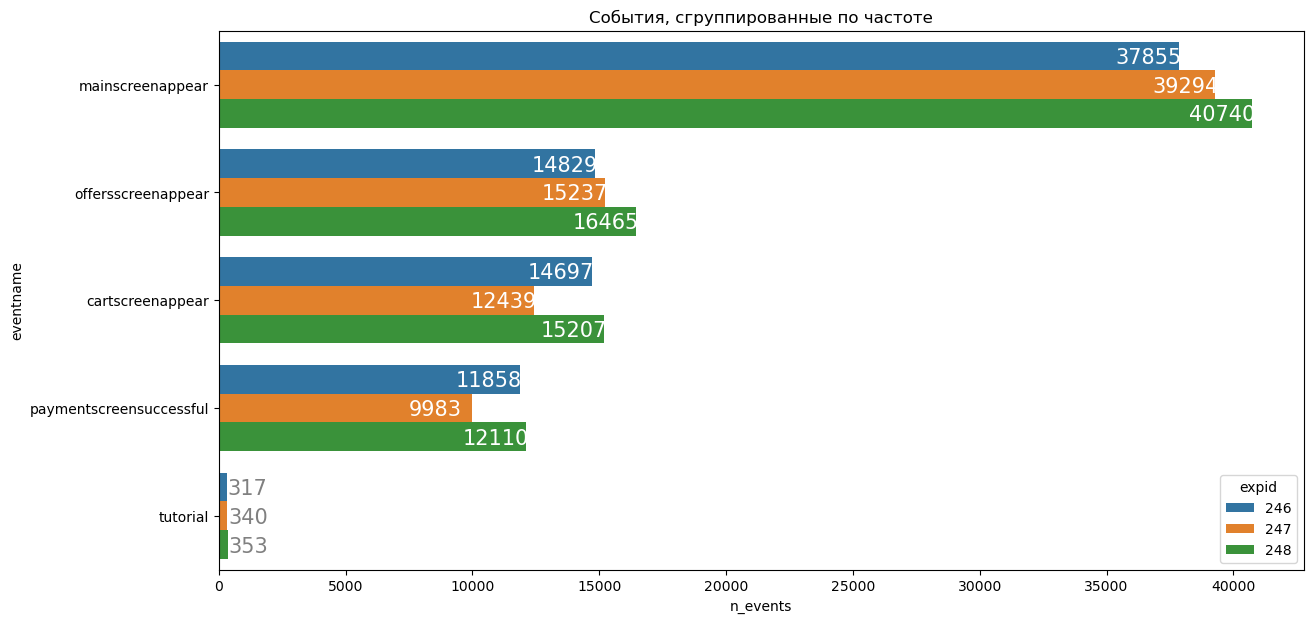

In [61]:
event_pivot

plt.figure(figsize=(14, 7))
ax = sns.barplot(y='eventname', x='n_events', order = order, hue='expid', data=event_pivot)
ax.set_title('События, сгруппированные по частоте')
for i in ax.patches:
    if i.get_width() > 9000:
        ax.text(i.get_width()-2500, i.get_y()+0.2, 
                str(int(i.get_width())), fontsize=15, color='white')
    else:
        ax.text(i.get_width()+30, i.get_y()+0.2, 
                str(int(i.get_width())), fontsize=15, color='grey')
plt.show()

Проверяю, будет ли отличие между группами статистически достоверным:

In [62]:
logs.groupby('expid').agg({'deviceidhash': ['count', 'nunique']})

deviceidhash        
             count nunique
expid                     
246          79556    2484
247          77293    2517
248          84875    2537

* count - общее количество пользователей в группе
* nunique - число пользователей, совершивших событие

In [63]:
event_pivot = logs.pivot_table(index=['eventname', 'expid'], values='deviceidhash', aggfunc=['count', 'nunique']).reset_index()
event_pivot.columns= ['eventname', 'expid', 'n_events', 'n_users']

display(event_pivot);

eventname  expid  n_events  n_users
0          cartscreenappear    246     14697     1266
1          cartscreenappear    247     12439     1239
2          cartscreenappear    248     15207     1231
3          mainscreenappear    246     37855     2450
4          mainscreenappear    247     39294     2479
5          mainscreenappear    248     40740     2494
6        offersscreenappear    246     14829     1542
7        offersscreenappear    247     15237     1524
8        offersscreenappear    248     16465     1531
9   paymentscreensuccessful    246     11858     1200
10  paymentscreensuccessful    247      9983     1158
11  paymentscreensuccessful    248     12110     1182
12                 tutorial    246       317      278
13                 tutorial    247       340      284
14                 tutorial    248       353      281

In [64]:
event_nunique = pd.pivot_table(logs, index='eventname', values='deviceidhash', columns ='expid', aggfunc='nunique').reset_index()

display(event_nunique);

expid                eventname   246   247   248
0             cartscreenappear  1266  1239  1231
1             mainscreenappear  2450  2479  2494
2           offersscreenappear  1542  1524  1531
3      paymentscreensuccessful  1200  1158  1182
4                     tutorial   278   284   281

In [65]:
event_count = pd.pivot_table(logs, index='eventname', values='deviceidhash', columns ='expid', aggfunc='count').reset_index()

display(event_count);

expid                eventname    246    247    248
0             cartscreenappear  14697  12439  15207
1             mainscreenappear  37855  39294  40740
2           offersscreenappear  14829  15237  16465
3      paymentscreensuccessful  11858   9983  12110
4                     tutorial    317    340    353

In [66]:
main_users_246 = event_nunique.loc[event_nunique['eventname'] == 'mainscreenappear', 246]
main_users_247 = event_nunique.loc[event_nunique['eventname'] == 'mainscreenappear', 247]
main_users_248 = event_nunique.loc[event_nunique['eventname'] == 'mainscreenappear', 248]
offer_users_246 = event_nunique.loc[event_nunique['eventname'] == 'offersscreenappear', 246]
offer_users_247 = event_nunique.loc[event_nunique['eventname'] == 'offersscreenappear', 247]
offer_users_248 = event_nunique.loc[event_nunique['eventname'] == 'offersscreenappear', 248]
carts_users_246 = event_nunique.loc[event_nunique['eventname'] == 'cartscreenappear', 246]
carts_users_247 = event_nunique.loc[event_nunique['eventname'] == 'cartscreenappear', 247]
carts_users_248 = event_nunique.loc[event_nunique['eventname'] == 'cartscreenappear', 248]
payment_users_246 = event_nunique.loc[event_nunique['eventname'] == 'paymentscreensuccessful', 246]
payment_users_247 = event_nunique.loc[event_nunique['eventname'] == 'paymentscreensuccessful', 247]
payment_users_248 = event_nunique.loc[event_nunique['eventname'] == 'paymentscreensuccessful', 248]

display(main_users_246)
display(main_users_247)
display(main_users_248)
display(offer_users_246)
display(offer_users_247)
display(offer_users_248)
display(carts_users_246)
display(carts_users_247)
display(carts_users_248)
display(payment_users_246)
display(payment_users_247)
display(payment_users_248);

1    2450
Name: 246, dtype: int64

1    2479
Name: 247, dtype: int64

1    2494
Name: 248, dtype: int64

2    1542
Name: 246, dtype: int64

2    1524
Name: 247, dtype: int64

2    1531
Name: 248, dtype: int64

0    1266
Name: 246, dtype: int64

0    1239
Name: 247, dtype: int64

0    1231
Name: 248, dtype: int64

3    1200
Name: 246, dtype: int64

3    1158
Name: 247, dtype: int64

3    1182
Name: 248, dtype: int64

In [67]:
main_events_246 = event_count.loc[event_count['eventname'] == 'mainscreenappear', 246]
main_events_247 = event_count.loc[event_count['eventname'] == 'mainscreenappear', 247]
main_events_248 = event_count.loc[event_count['eventname'] == 'mainscreenappear', 248]
offer_events_246 = event_count.loc[event_count['eventname'] == 'offersscreenappear', 246]
offer_events_247 = event_count.loc[event_count['eventname'] == 'offersscreenappear', 247]
offer_events_248 = event_count.loc[event_count['eventname'] == 'offersscreenappear', 248]
carts_events_246 = event_count.loc[event_count['eventname'] == 'cartscreenappear', 246]
carts_events_247 = event_count.loc[event_count['eventname'] == 'cartscreenappear', 247]
carts_events_248 = event_count.loc[event_count['eventname'] == 'cartscreenappear', 248]
payment_events_246 = event_count.loc[event_count['eventname'] == 'paymentscreensuccessful', 246]
payment_events_247 = event_count.loc[event_count['eventname'] == 'paymentscreensuccessful', 247]
payment_events_248 = event_count.loc[event_count['eventname'] == 'paymentscreensuccessful', 248]

display(main_events_246)
display(main_events_247)
display(main_events_248)
display(offer_events_246)
display(offer_events_247)
display(offer_events_248)
display(carts_events_246)
display(carts_events_247)
display(carts_events_248)
display(payment_events_246)
display(payment_events_247)
display(payment_events_248);

1    37855
Name: 246, dtype: int64

1    39294
Name: 247, dtype: int64

1    40740
Name: 248, dtype: int64

2    14829
Name: 246, dtype: int64

2    15237
Name: 247, dtype: int64

2    16465
Name: 248, dtype: int64

0    14697
Name: 246, dtype: int64

0    12439
Name: 247, dtype: int64

0    15207
Name: 248, dtype: int64

3    11858
Name: 246, dtype: int64

3    9983
Name: 247, dtype: int64

3    12110
Name: 248, dtype: int64

**Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?**

In [68]:
alpha = 0.05

**Сравниваем конверсии для посещения Главной Страницы (mainscreenappear):**

Сформулируем гипотезы:

* H0: Различий в долях групп 246 и 247 нет
* H1: Между долями групп 246 и 247 есть значимая разница

Сравниваю группы 246 и 247:

In [69]:
hypothesis_test(main_users_246, main_users_247, main_events_246, main_events_247, alpha)

p-значение:  [0.35408459]
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Согласно проведенным тестам, различие между контрольными группа 246 и 247 статистически незначимо, поэтому можно сказать, что разбиение на группы работает корректно.**

Сравниваю группы 246 и 248:

Сформулируем гипотезы:

* H0: Различий в долях групп 246 и 248 нет
* H1: Между долями групп 246 и 248 есть значимая разница

In [70]:
hypothesis_test(main_users_246, main_users_248, main_events_246, main_events_248, alpha)

p-значение:  [0.04326258]
уровень значимости:  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница


Сравниваю группы 247 и 248:

Сформулируем гипотезы:

* H0: Различий в долях групп 247 и 248 нет
* H1: Между долями групп 247 и 248 есть значимая разница

In [71]:
hypothesis_test(main_users_247, main_users_248, main_events_247, main_events_248, alpha)

p-значение:  [0.27300591]
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Сравниваем конверсии для посещения Страницы Предложений (offersscreenappear):**

Сравниваю группы 246 и 247:

In [72]:
hypothesis_test(offer_users_246, offer_users_247, offer_events_246, offer_events_247, alpha)

p-значение:  [0.25593249]
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваю группы 246 и 248:

In [73]:
hypothesis_test(offer_users_246, offer_users_248, offer_events_246, offer_events_248, alpha)

p-значение:  [0.00109401]
уровень значимости:  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница


Сравниваю группы 247 и 248:

In [74]:
hypothesis_test(offer_users_247, offer_users_248, offer_events_247, offer_events_248, alpha)

p-значение:  [0.0339524]
уровень значимости:  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Сравниваем конверсии для посещения Страницы С Корзиной (cartscreenappear):**

Сравниваю группы 246 и 247:

In [75]:
hypothesis_test(carts_users_246, carts_users_247, carts_events_246, carts_events_247, alpha)

p-значение:  [0.00013435]
уровень значимости:  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница


Сравниваю группы 246 и 248:

In [76]:
hypothesis_test(carts_users_246, carts_users_248, carts_events_246, carts_events_248, alpha)

p-значение:  [0.10479037]
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваю группы 247 и 248:

In [77]:
hypothesis_test(carts_users_247, carts_users_248, carts_events_247, carts_events_248, alpha)

p-значение:  [6.2928053e-08]
уровень значимости:  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Сравниваем конверсии для посещения Страницы С Успешным Завершением Платежа (paymentscreensuccessful):**

Сравниваю группы 246 и 247:

In [78]:
hypothesis_test(payment_users_246, payment_users_247, payment_events_246, payment_events_247, alpha)

p-значение:  [0.0004465]
уровень значимости:  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница


Сравниваю группы 246 и 248:

In [79]:
hypothesis_test(payment_users_246, payment_users_248, payment_events_246, payment_events_248, alpha)

p-значение:  [0.35268532]
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваю группы 247 и 248:

In [80]:
hypothesis_test(payment_users_247, payment_users_248, payment_events_247, payment_events_248, alpha)

p-значение:  [9.81904777e-06]
уровень значимости:  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Группирую тесты по группам:**

**Сравниваю группы 246 и 247:**

Сравниваем конверсии для посещения Главной Страницы (mainscreenappear):

In [81]:
hypothesis_test(main_users_246, main_users_247, main_events_246, main_events_247, alpha)

p-значение:  [0.35408459]
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [82]:
z_test(main_users_246, main_users_247, main_events_246, main_events_247, alpha)

p-значение:  [0.35408459]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [83]:
z_test(main_users_246, main_users_247, main_events_246, main_events_247, alpha)

p-значение:  [0.35408459]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы Предложений (offersscreenappear):

In [84]:
hypothesis_test(offer_users_246, offer_users_247, offer_events_246, offer_events_247, alpha)

p-значение:  [0.25593249]
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [85]:
z_test(offer_users_246, offer_users_247, offer_events_246, offer_events_247, alpha)

p-значение:  [0.25593249]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы С Корзиной (cartscreenappear):

In [86]:
hypothesis_test(carts_users_246, carts_users_247, carts_events_246, carts_events_247, alpha)

p-значение:  [0.00013435]
уровень значимости:  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [87]:
z_test(carts_users_246, carts_users_247, carts_events_246, carts_events_247, alpha)

p-значение:  [0.00013435]
уровень значимости:  0.003125
Отвергаем нулевую гипотезу: между долями есть значимая разница


Сравниваем конверсии для посещения Страницы С Успешным Завершением Платежа (paymentscreensuccessful):

In [88]:
hypothesis_test(payment_users_246, payment_users_247, payment_events_246, payment_events_247, alpha)

p-значение:  [0.0004465]
уровень значимости:  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [89]:
z_test(payment_users_246, payment_users_247, payment_events_246, payment_events_247, alpha)

p-значение:  [0.0004465]
уровень значимости:  0.003125
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Сравниваю группы 246 и 248:**

Сравниваем конверсии для посещения Главной Страницы (mainscreenappear):

In [90]:
hypothesis_test(main_users_246, main_users_248, main_events_246, main_events_248, alpha)

p-значение:  [0.04326258]
уровень значимости:  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница


Сравниваем конверсии для посещения Страницы Предложений (offersscreenappear):

In [91]:
hypothesis_test(offer_users_246, offer_users_248, offer_events_246, offer_events_248, alpha)

p-значение:  [0.00109401]
уровень значимости:  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница


Сравниваем конверсии для посещения Страницы С Корзиной (cartscreenappear):

In [92]:
hypothesis_test(carts_users_246, carts_users_248, carts_events_246, carts_events_248, alpha)

p-значение:  [0.10479037]
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы С Успешным Завершением Платежа (paymentscreensuccessful):

In [93]:
hypothesis_test(payment_users_246, payment_users_248, payment_events_246, payment_events_248, alpha)

p-значение:  [0.35268532]
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Сравниваю группы 247 и 248:**

Сравниваем конверсии для посещения Главной Страницы (mainscreenappear):

In [94]:
hypothesis_test(main_users_247, main_users_248, main_events_247, main_events_248, alpha)

p-значение:  [0.27300591]
уровень значимости:  0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы Предложений (offersscreenappear):

In [95]:
hypothesis_test(offer_users_247, offer_users_248, offer_events_247, offer_events_248, alpha)

p-значение:  [0.0339524]
уровень значимости:  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница


Сравниваем конверсии для посещения Страницы С Корзиной (cartscreenappear):

In [96]:
hypothesis_test(carts_users_247, carts_users_248, carts_events_247, carts_events_248, alpha)

p-значение:  [6.2928053e-08]
уровень значимости:  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница


Сравниваем конверсии для посещения Страницы С Успешным Завершением Платежа (paymentscreensuccessful):

In [97]:
hypothesis_test(payment_users_247, payment_users_248, payment_events_247, payment_events_248, alpha)

p-значение:  [9.81904777e-06]
уровень значимости:  0.05
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Готовлю таблички для тестов:**

In [98]:
users_by_expid = logs.groupby('expid').agg({'deviceidhash': 'nunique'})

display(users_by_expid);

deviceidhash
expid              
246            2484
247            2517
248            2537

In [99]:
event_nunique = pd.pivot_table(logs, index='eventname', values='deviceidhash', columns ='expid', aggfunc='nunique').sort_values(by=246, ascending=False)

display(event_nunique);

expid                     246   247   248
eventname                                
mainscreenappear         2450  2479  2494
offersscreenappear       1542  1524  1531
cartscreenappear         1266  1239  1231
paymentscreensuccessful  1200  1158  1182
tutorial                  278   284   281

In [100]:
event_n = logs.groupby('expid').agg({'deviceidhash': 'nunique'})

display(event_n);

deviceidhash
expid              
246            2484
247            2517
248            2537

**Начинаю тесты:**

**Сравниваю группы 246 и 247:**

Сформулируем гипотезы:
* Нулевая: Различий в долях групп 246 и 247 нет
* Альтернативая: Между долями групп 247 и 248 есть значимая разница

Сравниваем конверсии для посещения Главной Страницы (mainscreenappear):

In [101]:
z_test(event_nunique.loc['mainscreenappear', 246], event_nunique.loc['mainscreenappear', 247], event_n.loc[246], event_n.loc[247], alpha)

p-значение:  [0.67562177]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы Предложений (offersscreenappear):

In [102]:
z_test(event_nunique.loc['offersscreenappear', 246], event_nunique.loc['offersscreenappear', 247], event_n.loc[246], event_n.loc[247], alpha)

p-значение:  [0.26698769]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы С Корзиной (cartscreenappear):

In [103]:
z_test(event_nunique.loc['cartscreenappear', 246], event_nunique.loc['cartscreenappear', 247], event_n.loc[246], event_n.loc[247], alpha)

p-значение:  [0.21828121]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы С Успешным Завершением Платежа (paymentscreensuccessful):

In [104]:
z_test(event_nunique.loc['paymentscreensuccessful', 246], event_nunique.loc['paymentscreensuccessful', 247], event_n.loc[246], event_n.loc[247], alpha)

p-значение:  [0.10298395]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Попытка сделать цикл

for i in range(len(event_n)):

    display(event_n['deviceidhash'][i])
    z_test(event_n[246][i], event_n[247][i], event_nunique[246][i], event_nunique[247][i], alpha)

**Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?**

**Сравниваю группы 246 и 248:**

Сформулируем гипотезы:
* Нулевая: Различий в долях групп 246 и 248 нет
* Альтернативая: Между долями групп 247 и 248 есть значимая разница

Сравниваем конверсии для посещения Главной Страницы (mainscreenappear):

In [105]:
z_test(event_nunique.loc['mainscreenappear', 246], event_nunique.loc['mainscreenappear', 248], event_n.loc[246], event_n.loc[248], alpha)

p-значение:  [0.34705881]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы Предложений (offersscreenappear):

In [106]:
z_test(event_nunique.loc['offersscreenappear', 246], event_nunique.loc['offersscreenappear', 248], event_n.loc[246], event_n.loc[248], alpha)

p-значение:  [0.20836205]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы С Корзиной (cartscreenappear):

In [107]:
z_test(event_nunique.loc['cartscreenappear', 246], event_nunique.loc['cartscreenappear', 248], event_n.loc[246], event_n.loc[248], alpha)

p-значение:  [0.08328413]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы С Успешным Завершением Платежа (paymentscreensuccessful):

In [108]:
z_test(event_nunique.loc['paymentscreensuccessful', 246], event_nunique.loc['paymentscreensuccessful', 248], event_n.loc[246], event_n.loc[248], alpha)

p-значение:  [0.22269359]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Сравниваю группы 247 и 248:**

Сформулируем гипотезы:
* Нулевая: Различий в долях групп 247 и 248 нет
* Альтернативая: Между долями групп 247 и 248 есть значимая разница

Сравниваем конверсии для посещения Главной Страницы (mainscreenappear):

In [109]:
z_test(event_nunique.loc['mainscreenappear', 247], event_nunique.loc['mainscreenappear', 248], event_n.loc[247], event_n.loc[248], alpha)

p-значение:  [0.60016616]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы Предложений (offersscreenappear):

In [110]:
z_test(event_nunique.loc['offersscreenappear', 247], event_nunique.loc['offersscreenappear', 248], event_n.loc[247], event_n.loc[248], alpha)

p-значение:  [0.88359567]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы С Корзиной (cartscreenappear):

In [111]:
z_test(event_nunique.loc['cartscreenappear', 247], event_nunique.loc['cartscreenappear', 248], event_n.loc[247], event_n.loc[248], alpha)

p-значение:  [0.61695175]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы С Успешным Завершением Платежа (paymentscreensuccessful):

In [112]:
z_test(event_nunique.loc['paymentscreensuccessful', 247], event_nunique.loc['paymentscreensuccessful', 248], event_n.loc[247], event_n.loc[248], alpha)

p-значение:  [0.67754136]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Сравниваю объединённые группы 246+247 и 248:**

Сформулируем гипотезы:
* Нулевая: Различий в долях групп 246+247 и 248 нет
* Альтернативая: Между долями групп 246+247 и 248 есть значимая разница

Складываю значения групп 246 и 247:

In [113]:
mainscreenappear_aa = (event_nunique.loc['mainscreenappear', 246]+event_nunique.loc['mainscreenappear', 247])
offersscreenappear_aa = (event_nunique.loc['offersscreenappear', 246]+event_nunique.loc['offersscreenappear', 247])
cartscreenappear_aa = (event_nunique.loc['cartscreenappear', 246]+event_nunique.loc['cartscreenappear', 247])
paymentscreensuccessful_aa = (event_nunique.loc['paymentscreensuccessful', 247]+event_nunique.loc['paymentscreensuccessful', 247])
event_n_aa = (event_n.loc[246]+event_n.loc[247])

Сравниваем конверсии для посещения Главной Страницы (mainscreenappear):

In [114]:
z_test(mainscreenappear_aa, event_nunique.loc['mainscreenappear', 248], event_n_aa, event_n.loc[248], alpha)

p-значение:  [0.39298915]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы Предложений (offersscreenappear):

In [115]:
z_test(offersscreenappear_aa, event_nunique.loc['offersscreenappear', 248], event_n_aa, event_n.loc[248], alpha)

p-значение:  [0.41899828]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы С Корзиной (cartscreenappear):

In [116]:
z_test(cartscreenappear_aa, event_nunique.loc['cartscreenappear', 248], event_n_aa, event_n.loc[248], alpha)

p-значение:  [0.19819341]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравниваем конверсии для посещения Страницы С Успешным Завершением Платежа (paymentscreensuccessful):

In [117]:
z_test(paymentscreensuccessful_aa, event_nunique.loc['paymentscreensuccessful', 248], event_n_aa, event_n.loc[248], alpha)

p-значение:  [0.81800245]
уровень значимости:  0.003125
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод по результатам тестов:**

Согласно проведенным тестам различия между контрольными группами 246 и 247 и экспериментальной 248 являются статистически незначимыми. Таким образом можно сказать, что изменение шрифтов во всем приложении не повлияло на воронку продаж, и пользователи переходят от шага к шагу в одинаковых пропорциях, независимо от шрифта приложения.

**Определим какой уровень значимости выбрать при проверке статистических гипотез выше. Посчитаем, сколько проверок статистических гипотез было сделано. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Сделаем вывод о том, какой уровень значимости стоит применить.**

При проверке гипотез выше я выбрал уровень значимости 0.05 / 16 (о методу Бонферрони), так как мы проводим 16 статистических тестов. Хотя при уровне значимости в 0.05 гипотезы так же не отвергались и можно было уровень значимости не снижать.

### Выводы:

* Общее количество событий в (сырые данные) логах - 243713
* Количество пользователей (сырые данные) - 7551
* Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные», поэтому мы сделали срез и фактический диапазон дат стал с с 21:00 31.07.2019 по 21:00 07.08.2019.
* Самое популярное событие - MainScreenAppear
* Событие, которое реже всего используется пользователями - Tutorial
* Как видим, цепочка выглядит как MainScreenAppear (главный экран) > OffersScreenAppear (экран предложения) > CartScreenAppear (корзина) > PaymentScreenSuccessful (старница успешной оплаты) сам же этам Tutorial (руководство) редко используется пользователями
* Больше всего пользователей теряется на этапе перехода из MainScreenAppear к OffersScreenAppear

При условии:

* alpha .01 - значимая разница для комбинации между группами 247 и 248 для событий PaymentScreenSuccessful | CartScreenAppear
* alpha .05 - значимая разница для комбинации между группами 247 и 248 для PaymentScreenSuccessful | CartScreenAppear и значимая разница между объедененными группами А1/А2 и группой В для PaymentScreenSuccessful | CartScreenAppear
* alpha .1 - значимая разница для комбинации между группами 247 и 248 для PaymentScreenSuccessful | CartScreenAppear и значимая разница между объедененными группами А1/А2 и группой В для PaymentScreenSuccessful | CartScreenAppear